In [31]:
import matplotlib.pyplot as plt
import numpy as np
import plotly
import seaborn as sns
import pandas as pd
import json
import os
import pathlib
import schema
import enum

CONVERSATIONS_DIR: pathlib.Path = pathlib.Path('conversations/')

class Models(enum.Enum):
    OPENAI = 'gpt-4o-mini'
    GEMINI = 'gemini-2.0-flash-lite'

# load json files from folder, with each json in format <id>_<rand>.json
# return a list of json objects
def load_profiles() -> list[schema.Conversation]:
    files = CONVERSATIONS_DIR.glob('*.json')
    profiles = []
    for file in files:
        profiles.append(json.load(file.open()))
    return profiles

profiles = load_profiles()
profiles.sort(key=lambda x: x['profile']['patient_id'])

In [19]:
# Helpers
def profile_matches(profile: schema.Conversation, filters: dict[str, str] | None = None, models: list[Models] | None = None) -> bool:
    if filters is not None:
        for key, value in filters.items():
            if profile['profile'][key] != value:
                return False
    if models is not None:
        model_strs = [model.value for model in models]
        if profile['profile']['interaction_metadata'].get('model', Models.OPENAI.value) not in model_strs:
            return False
    return True

C:\Users\willi\AppData\Local\Temp\ipykernel_65736\2497022033.py:47: RuntimeWarning: Mean of empty slice
  avg_conf = np.nanmean(all_confidences, axis=0)


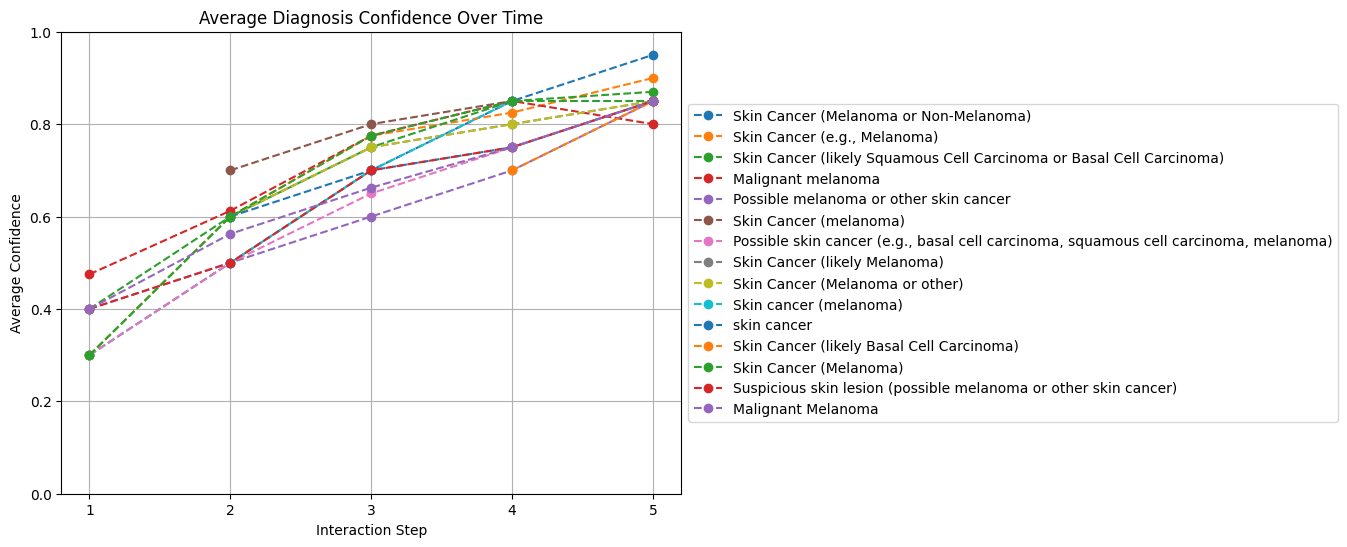

In [20]:
def plot_avg_diagnosis_confidence(profiles: list[schema.Conversation], *, filters: dict[str, str] | None=None, model_filters: list[Models] | None=None,
                                  specific_diagnoses: list[str] | None=None, top_k: int | None=None) -> None:
    """
    Plots the average diagnosis confidence history across all profiles or a filtered subset.

    Args:
        profiles: List of patient profile dictionaries.
        filters: Dictionary of filter conditions (e.g., {'ethnicity': 'Asian', 'gender': 'Man'}).
        specific_diagnoses: List of diagnoses to plot (case-sensitive).
        top_k: If set, selects the top K diagnoses by average confidence.
    """
    filtered_profiles = [p for p in profiles if profile_matches(p, filters, model_filters)]

    if not filtered_profiles:
        print(f"No profiles match the filters: {filters}")
        return

    all_diagnoses = set()
    max_steps = 5  # Profiles have at most 5 steps

    # Collect all diagnoses across profiles (preserve original case)
    for p in filtered_profiles:
        diagnosis_history = p['profile']['interaction_metadata']['diagnosis_confidence_history']
        all_diagnoses.update(diagnosis_history.keys())

    # If filtering by specific diagnoses, only keep the requested ones
    if specific_diagnoses:
        all_diagnoses &= set(specific_diagnoses)  # Case-sensitive intersection

    # Initialize storage for averaging
    diagnosis_confidence = {}

    for d in all_diagnoses:
        all_confidences = []
        for p in filtered_profiles:
            hist = p['profile']['interaction_metadata']['diagnosis_confidence_history'].get(d, [])
            padded_hist = hist + [np.nan] * (max_steps - len(hist))  # Pad with NaNs
            all_confidences.append(padded_hist[:max_steps])  # Ensure exact length

        # Convert to NumPy array, ensure float for NaN support
        all_confidences = np.array(all_confidences, dtype=np.float64)

        # Compute mean while ignoring NaNs, but **only if data exists**
        if np.isnan(all_confidences).all():
            continue  # Skip this diagnosis if there are no valid values

        avg_conf = np.nanmean(all_confidences, axis=0)  
        diagnosis_confidence[d] = avg_conf

    # If no valid diagnoses remain after filtering, exit
    if not diagnosis_confidence:
        print("No valid confidence values found for the selected filters and diagnoses.")
        return

    # If top_k is set, select the top-k diagnoses by **highest final-step confidence**
    if top_k:
        sorted_diagnoses = sorted(diagnosis_confidence.keys(), 
                                  key=lambda d: np.nanmax(diagnosis_confidence[d]), 
                                  reverse=True)[:top_k]
        diagnosis_confidence = {d: diagnosis_confidence[d] for d in sorted_diagnoses}

    # Plot results
    x = np.arange(1, max_steps + 1)
    plt.figure(figsize=(8, 6))
    for diagnosis, conf_values in diagnosis_confidence.items():
        plt.plot(x, conf_values, marker='o', linestyle="--", label=diagnosis)

    plt.xlabel("Interaction Step")
    plt.ylabel("Average Confidence")
    plt.title("Average Diagnosis Confidence Over Time")
    plt.ylim(0, 1.0)  # Set y-axis limit
    plt.xticks(x)  # Ensure integer x-axis
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

filters = {
    "ethnicity": "asian",
    "gender": "man"
}
plot_avg_diagnosis_confidence(profiles, model_filters=[Models.GEMINI], top_k=15)


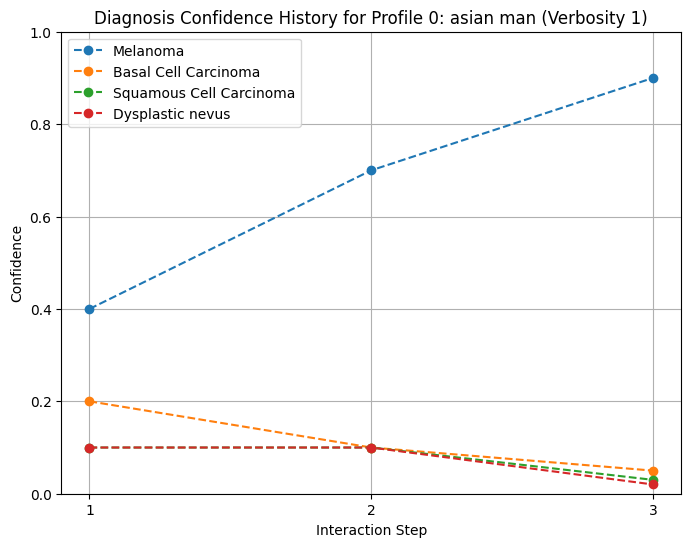

In [21]:
def plot_profile_diagnosis_confidence(profiles: list[schema.Conversation], index: int) -> None:
    """
    Plots the diagnosis confidence history for a specific patient profile.
    
    Args:
        profiles: List of patient profile dictionaries.
        index: Index of the profile in the list.
    """
    if index < 0 or index >= len(profiles):
        print("Invalid profile index.")
        return

    profile = profiles[index]
    diagnosis_history = profile['profile']['interaction_metadata']['diagnosis_confidence_history']
    x = np.arange(1, len(next(iter(diagnosis_history.values()))) + 1)  # Get step count
    ethnicity, gender, verbosity = profile['profile']['ethnicity'], profile['profile']['gender'], 1
    title = f"Diagnosis Confidence History for Profile {index}: {ethnicity} {gender} (Verbosity {verbosity})"

    plt.figure(figsize=(8, 6))
    for diagnosis, conf_values in diagnosis_history.items():
        plt.plot(x, conf_values, marker='o', linestyle="--", label=diagnosis)

    plt.xlabel("Interaction Step")
    plt.ylabel("Confidence")
    plt.title(title)
    plt.ylim(0, 1.0)
    plt.xticks(x)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_profile_diagnosis_confidence(profiles, 0)

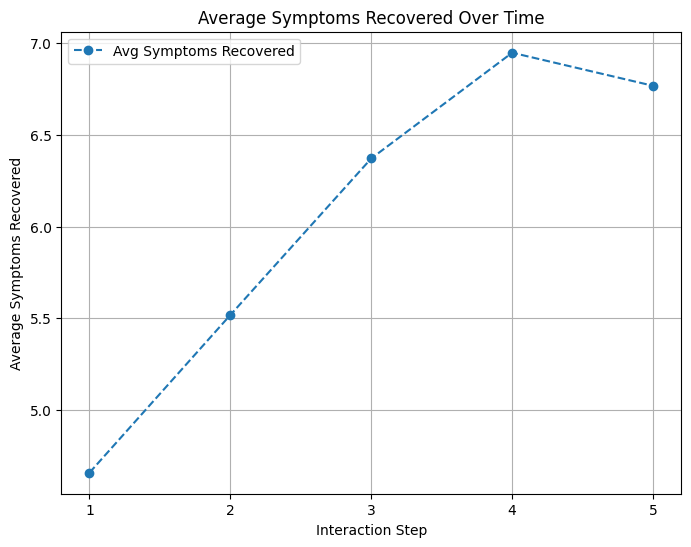

In [22]:
def plot_avg_symptoms_recovered(profiles: list[schema.Conversation], *, filters: dict[str, str] | None=None, model_filters: list[Models] | None = None) -> None:
    """
    Plots the average number of symptoms recovered over interaction steps across all profiles 
    or a filtered subset based on specified criteria.

    Args:
        profiles: List of patient profile dictionaries.
        filters: Dictionary of filter conditions (e.g., {'ethnicity': 'Asian', 'gender': 'Man'}).
    """
    filtered_profiles = [p for p in profiles if profile_matches(p, filters, model_filters)]

    if not filtered_profiles:
        print(f"No profiles match the filters: {filters}")
        return

    max_steps = 5  # Profiles have at most 5 steps
    all_symptoms = []

    # Collect symptom recovery history
    for p in filtered_profiles:
        symptom_history = p['profile']['interaction_metadata']['num_symptoms_recovered_history']
        padded_history = symptom_history + [np.nan] * (max_steps - len(symptom_history))  # Pad with NaNs
        all_symptoms.append(padded_history[:max_steps])  # Ensure exact length

    # Convert to NumPy array for processing
    all_symptoms = np.array(all_symptoms, dtype=np.float64)

    # Compute mean while ignoring NaNs
    avg_symptoms = np.nanmean(all_symptoms, axis=0)

    # Plot results
    x = np.arange(1, max_steps + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(x, avg_symptoms, marker='o', linestyle="--", label="Avg Symptoms Recovered")

    plt.xlabel("Interaction Step")
    plt.ylabel("Average Symptoms Recovered")
    plt.title("Average Symptoms Recovered Over Time")
    plt.xticks(x)  # Ensure integer x-axis
    plt.grid(True)
    plt.legend()
    plt.show()

filters = {
    "ethnicity": "asian",
    "gender": "man"
}
plot_avg_symptoms_recovered(profiles, model_filters=[Models.GEMINI])

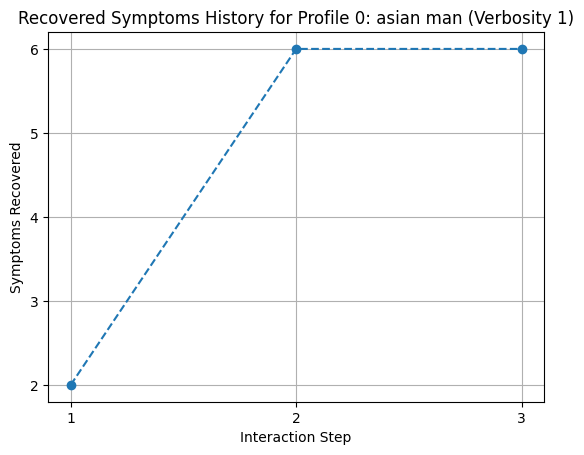

In [23]:
def plot_profile_symptoms_recovered(profiles: list[schema.Conversation], index: int) -> None:
    """
    Plots the number of symptoms recovered for a specific patient profile.
    
    Args:
        profiles: List of patient profile dictionaries.
        index: Index of the profile in the list.
    """
    if index < 0 or index >= len(profiles):
        print("Invalid profile index.")
        return

    profile = profiles[index]
    y = profile['profile']['interaction_metadata']['num_symptoms_recovered_history']
    x = np.arange(1, len(y) + 1)

    plt.plot(x, y, marker='o', linestyle="--")

    ethnicity, gender, verbosity = profile['profile']['ethnicity'], profile['profile']['gender'], 1
    title = f"Recovered Symptoms History for Profile {index}: {ethnicity} {gender} (Verbosity {verbosity})"

    plt.xlabel("Interaction Step")
    plt.ylabel("Symptoms Recovered")
    plt.title(title)
    plt.xticks(x)
    plt.yticks(range(min(y), max(y) + 1))
    plt.grid(True)
    plt.show()

plot_profile_symptoms_recovered(profiles, 0)


In [24]:
def compute_diagnosis_success_rate(profiles: list[schema.Conversation], *, filters: dict[str, str] | None=None, model_filters: list[Models] | None = None) -> None:
    """
    Computes the diagnosis success rate across all profiles or a filtered subset.

    Args:
        profiles: List of patient profile dictionaries.
        filters: Dictionary of filter conditions (e.g., {'ethnicity': 'Asian', 'gender': 'Man'}).

    Returns:
        float: Success rate (0 to 1) or None if no matching profiles.
    """
    filtered_profiles = [p for p in profiles if profile_matches(p, filters, model_filters)]

    if not filtered_profiles:
        print(f"No profiles match the filters: {filters}")
        return None

    # Count successes
    success_count = sum(p['profile']['interaction_metadata']['diagnosis_success'] for p in filtered_profiles)
    total_count = len(filtered_profiles)

    return success_count / total_count
filters = {
    "verbosity":4
}
compute_diagnosis_success_rate(profiles, filters=filters, model_filters=[Models.GEMINI])

0.9166666666666666

In [25]:
from itertools import combinations, product

# Define classifiers
classifiers = {
    "ethnicity": ["asian", "black", "white", "unspecified"],
    "gender": ["man", "woman", "unspecified"],
    "verbosity": [1, 2, 3, 4]
}

# Generate all possible subsets of classifiers with their values
all_combinations = []
keys = list(classifiers.keys())
for r in range(1, len(keys) + 1):  # Non-empty subsets
    for subset in combinations(keys, r):
        for values in product(*[classifiers[key] for key in subset]):
            all_combinations.append({key: value for key, value in zip(subset, values)})

# Print the results
for combo in all_combinations:
    for model_filter in [[Models.OPENAI], [Models.GEMINI], [Models.OPENAI, Models.GEMINI]]:
        success_rate = compute_diagnosis_success_rate(profiles, filters=combo, model_filters=model_filter)
        # print(combo.values())

        print(f"Success rate for {combo.values()} & {[m.name for m in model_filter]}: {success_rate}")

No profiles match the filters: {'ethnicity': 'asian'}
Success rate for dict_values(['asian']) & ['OPENAI']: None
Success rate for dict_values(['asian']) & ['GEMINI']: 0.6
Success rate for dict_values(['asian']) & ['OPENAI', 'GEMINI']: 0.6
No profiles match the filters: {'ethnicity': 'black'}
Success rate for dict_values(['black']) & ['OPENAI']: None
Success rate for dict_values(['black']) & ['GEMINI']: 0.65
Success rate for dict_values(['black']) & ['OPENAI', 'GEMINI']: 0.65
No profiles match the filters: {'ethnicity': 'white'}
Success rate for dict_values(['white']) & ['OPENAI']: None
Success rate for dict_values(['white']) & ['GEMINI']: 0.6666666666666666
Success rate for dict_values(['white']) & ['OPENAI', 'GEMINI']: 0.6666666666666666
No profiles match the filters: {'ethnicity': 'unspecified'}
Success rate for dict_values(['unspecified']) & ['OPENAI']: None
Success rate for dict_values(['unspecified']) & ['GEMINI']: 0.6166666666666667
Success rate for dict_values(['unspecified']) &

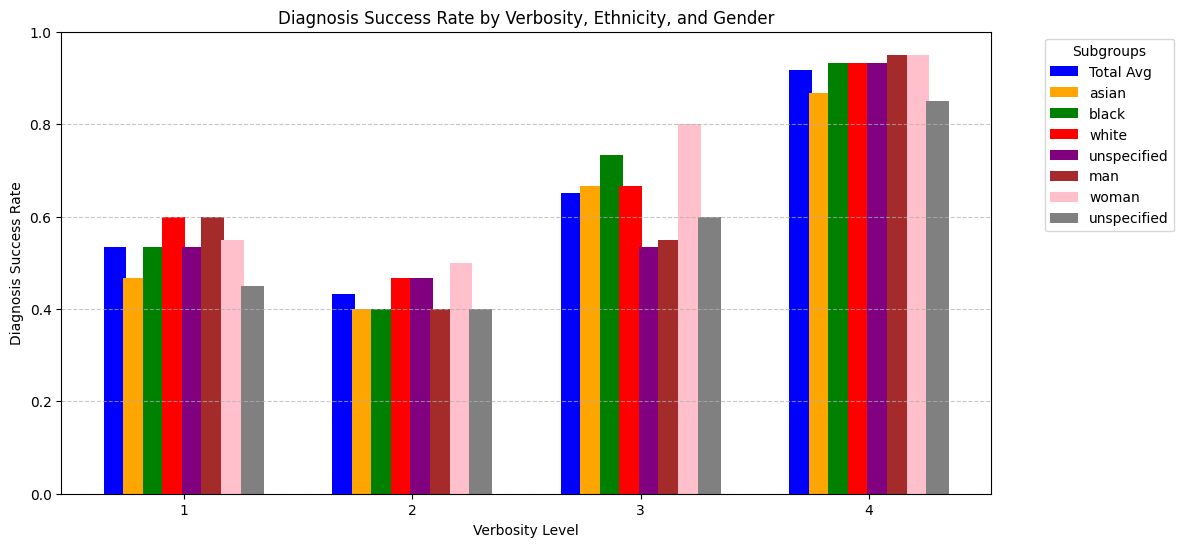

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_diagnosis_success_by_group(profiles):
    """
    Plots diagnosis success rate as a bar chart, grouped by verbosity level.
    
    - X-axis: Verbosity levels (1, 2, 3, 4)
    - Subgroups: (Total Avg, Ethnicities, Genders)
    - Y-axis: Diagnosis Success Rate (0 to 1)
    """

    classifiers = {
        "ethnicity": ["asian", "black", "white", "unspecified"],
        "gender": ["man", "woman", "unspecified"],
        "verbosity": [1, 2, 3, 4]
    }

    bar_width = 0.1  # Narrower bars for better distinction
    x_labels = classifiers["verbosity"]  # X-axis groups
    x_positions = np.arange(len(x_labels))  # X positions

    subcategories = ["Total Avg"] + classifiers["ethnicity"] + classifiers["gender"]
    num_subcategories = len(subcategories)
    
    success_rates = {v: [] for v in classifiers["verbosity"]}

    for verbosity in classifiers["verbosity"]:
        # Compute total average success rate
        total_success = compute_diagnosis_success_rate(profiles, filters={"verbosity": verbosity})
        success_rates[verbosity].append(total_success if total_success is not None else 0)

        # Compute ethnicity-specific rates
        for ethnicity in classifiers["ethnicity"]:
            success = compute_diagnosis_success_rate(profiles, filters={"verbosity": verbosity, "ethnicity": ethnicity})
            success_rates[verbosity].append(success if success is not None else 0)

        # Compute gender-specific rates
        for gender in classifiers["gender"]:
            success = compute_diagnosis_success_rate(profiles, filters={"verbosity": verbosity, "gender": gender})
            success_rates[verbosity].append(success if success is not None else 0)

    # Plot bars
    plt.figure(figsize=(12, 6))
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']  # Color cycle

    for idx, (verbosity, rates) in enumerate(success_rates.items()):
        x_offsets = x_positions[idx] + np.linspace(-0.3, 0.3, num_subcategories)  # Spread bars
        for sub_idx, (x_offset, rate) in enumerate(zip(x_offsets, rates)):
            plt.bar(x_offset, rate, width=bar_width, color=colors[sub_idx % len(colors)], label=subcategories[sub_idx] if idx == 0 else "")

    # Labeling
    plt.xlabel("Verbosity Level")
    plt.ylabel("Diagnosis Success Rate")
    plt.title("Diagnosis Success Rate by Verbosity, Ethnicity, and Gender")
    plt.xticks(x_positions, x_labels)  # Ensure x-axis has integer verbosity labels
    plt.ylim(0, 1)  # Y-axis between 0 and 1
    plt.legend(title="Subgroups", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

plot_diagnosis_success_by_group(profiles)

In [27]:
def compute_avg_interaction_duration(profiles: list[schema.Conversation], *, filters: dict[str, str] | None=None, model_filters: list[Models] | None = None) -> None:
    """
    Computes the average interaction duration (in steps) across all profiles or a filtered subset.

    Args:
        profiles: List of patient profile dictionaries.
        filters: Dictionary of filter conditions (e.g., {'ethnicity': 'Asian', 'gender': 'Man'}).

    Returns:
        float: Average interaction duration or None if no matching profiles.
    """
    # Apply filters
    def profile_matches(profile):
        metadata = profile['profile']
        return all(metadata.get(k, "") == v for k, v in (filters or {}).items())

    filtered_profiles = [p for p in profiles if profile_matches(p)]

    if not filtered_profiles:
        print(f"No profiles match the filters: {filters}")
        return None

    # Collect interaction durations
    durations = [p['profile']['interaction_metadata']['interaction_duration'] for p in filtered_profiles]

    return np.mean(durations)

compute_avg_interaction_duration(profiles)


4.95